# Simulation et estimation d'un processus de Hawkes linéaire univarié

In [45]:
import numpy as np
from scipy.stats import kstest
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Dans ce TP, on s'intéresse à un processus de Hawkes linéaire exponentiel univarié, dont les temps de saut sont notés $(T_k)_{k\geq 1}$, d'intensité 

$$\lambda(t)=\mu + \sum_{T_k \leq t} \alpha \beta \exp(-\beta(t-T_k)),$$

pour tout $t\in [0,T]$. 

On suppose que les paramètres vérifient les conditions suivantes : $\mu >0$, $0<\alpha <1$ et $\beta>0$.

## Simulation d'un processus de Hawkes par thinning

Ecrire une fonction qui prend en entrée $\mu$, $\alpha$, $\beta$, $T$ et qui renvoie les temps de saut d'une réalisation du processus sur $[0,T]$.

In [46]:
mu=1
alpha=0.5
beta=2
T=100

def simulate_hawkes(mu, alpha, beta, T):
    events = []
    t = 0.0
    last_t = 0.0
    current_lambda = mu

    while t < T:
        lambda_bar = current_lambda
        if lambda_bar <= 0:
            break
        w = np.random.exponential(1 / lambda_bar)
        t = t + w
        if t >= T:
            break
        lambda_t = mu + (current_lambda - mu) * np.exp(-beta * (t - last_t))
        if np.random.rand() <= lambda_t / lambda_bar:
            events.append(t)
            current_lambda = lambda_t + alpha * beta
        else:
            current_lambda = lambda_t
        last_t = t
    return np.array(events)

Remarque : Pour calculer l'intensité au temps candidat, on peut toujours utiliser la formule générale de l'intensité. Dans le cas exponentiel, l'intensité est markovienne, i.e. elle dépend uniquement de l'intensité au dernier temps de saut et du temps écoulé depuis ce dernier saut. On peut alors calculer l'intensité de façon récursive, ce qui est beaucoup moins coûteux en temps de calcul. Pour cela il faut exprimer l'intensité au temps candidat $t^\star$ en fonction de l'intensité au dernier temps $t$.

Tracer l'intensité simulée.

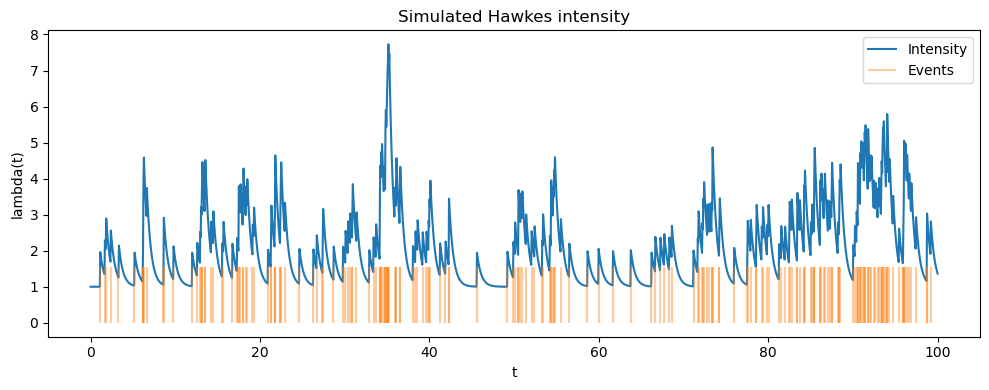

In [47]:
events = simulate_hawkes(mu, alpha, beta, T)
events = np.sort(events)

t_grid = np.linspace(0, T, 2000)
lambda_grid = np.empty_like(t_grid)

current_lambda = mu
last_t = 0.0
event_idx = 0

for i, t in enumerate(t_grid):
    while event_idx < len(events) and events[event_idx] <= t:
        t_event = events[event_idx]
        current_lambda = mu + (current_lambda - mu) * np.exp(-beta * (t_event - last_t))
        current_lambda += alpha * beta
        last_t = t_event
        event_idx += 1
    current_lambda = mu + (current_lambda - mu) * np.exp(-beta * (t - last_t))
    last_t = t
    lambda_grid[i] = current_lambda

plt.figure(figsize=(10, 4))
plt.plot(t_grid, lambda_grid, label="Intensity")
plt.vlines(events, ymin=0, ymax=lambda_grid.max() * 0.2, color="tab:orange", alpha=0.4, label="Events")
plt.xlabel("t")
plt.ylabel("lambda(t)")
plt.title("Simulated Hawkes intensity")
plt.legend()
plt.tight_layout()

## Comment vérifier la simulation ? 

On va utiliser une procédure d'ajustement qui est un corollaire du théorème de changement de temps (Daley et Vere-Jones, 2003). Ce théorème nous dit que pour un processus ponctuel $(T_k)_{k\geq 1}$ d'intensité $\lambda_\theta(t)$ et de compensateur $\Lambda_\theta(t)=\int_0^t \lambda_\theta(u) du$, le processus $(\Lambda_\theta(T_k))_{k\geq 1}$ est un processus de Poisson d'intensité 1. Autrement dit, les incréments du compensateur $(\Lambda_\theta(T_k))-\Lambda_\theta(T_{k-1})) \sim Exp (1)$. Cette propriété permet donc de formuler la procédure de test suivante pour le processus $(T_k)_{k\geq 1}$ simulé :

- Calculer le compensateur aux temps de sauts : $(\Lambda_\theta(T_k))_{k\geq 1}$

- Calculer les incréments $(\Lambda_\theta(T_k))-\Lambda_\theta(T_{k-1}))$

- Tester si ces incréments sont des exponentielles de paramètre 1, grâce à un test de Kolmogorov-Smirnov.


Ecrire une fonction qui prend en entrée les $T_k$, les paramètres $\mu$, $\alpha$ et $\beta$ et le temps t auquel on calcule le compensateur :

In [48]:
def compensator(events, mu, alpha, beta, t):
    events = np.asarray(events)
    if events.size == 0:
        return mu * t
    past_events = events[events <= t]
    if past_events.size == 0:
        return mu * t
    return mu * t + alpha * np.sum(1 - np.exp(-beta * (t - past_events)))

Calculer les incréments du compensateur avec la fonction **np.diff** puis utiliser la fonction **kstest** pour effectuer la procédure de test ci-dessus.

In [49]:
lambda_at_events = np.array([compensator(events, mu, alpha, beta, t) for t in events])
increments = np.diff(np.concatenate(([0.0], lambda_at_events)))

ks_stat, ks_pvalue = kstest(increments, "expon", args=(0, 1))
print(f"KS stat: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")

KS stat: 0.0357, p-value: 0.9304


## Estimation

### Fonction de vraisemblance

La log-vraisemblance d'un processus ponctuel d'intensité $\lambda_\theta(t)$ sur $[0, T]$ s'écrit :

$$ \ell_\theta(T) = \sum_{k=1}^{N(T)}log(\lambda_\theta(T_k^{-})) - \Lambda_\theta(T)$$

où $\lambda_\theta(T_k^{-})$ est l'intensité avant le temps de saut $T_k$.

Ecrire une fonction qui prend entrée les $T_k$, $\mu$, $\alpha$, $\beta$, $T$ et qui renvoie la vraisemblance (ou l'opposé de la vraisemblance, qu'on cherchera à minimiser à la question suivante).

In [50]:
def neg_log_likelihood(events, mu, alpha, beta, T):
    events = np.asarray(events)
    events = events[events <= T]
    if events.size == 0:
        return mu * T

    log_sum = 0.0
    last_t = 0.0
    lambda_after = mu

    for t in events:
        lambda_before = mu + (lambda_after - mu) * np.exp(-beta * (t - last_t))
        if lambda_before <= 0:
            return np.inf
        log_sum += np.log(lambda_before)
        lambda_after = lambda_before + alpha * beta
        last_t = t

    comp = compensator(events, mu, alpha, beta, T)
    return -(log_sum - comp)

### Maximum de vraisemblance

Calculer l'estimateur du maximum de vraisemblance à l'aide de la fonction **minimize**.

- Vous utiliserez la méthode d'optimisation "L-BFGS-B", qui permet notamment de minimiser sous contrainte.
-  Vous pourrez imposer les contraintes sur les paramètres qui doivent rester positifs et $\alpha < 1$ (condition de stabilité du processus).
- Pour l'initialisation, commencer par une initialisation proche des vrais paramètres puis si ça fonctionne, vous pourrez prendre une initialisation aléatoire.


In [51]:
n_paths = 50
events_list = [simulate_hawkes(mu, alpha, beta, T) for _ in range(n_paths)]

def neg_log_likelihood_multi(event_sequences, mu, alpha, beta, T):
    total = 0.0
    for seq in event_sequences:
        total += neg_log_likelihood(seq, mu, alpha, beta, T)
    return total

x0 = np.array([mu-0.01, alpha+0.01, beta-0.01], dtype=float)
bounds = [(1e-6, None), (1e-6, 0.999), (1e-6, None)]

res = minimize(
    lambda x: neg_log_likelihood_multi(events_list, x[0], x[1], x[2], T),
    x0,
    method="L-BFGS-B",
    bounds=bounds,
    options={"maxiter": 5000}
 )

print("Estimated params (mu, alpha, beta):", res.x)
print("Negative log-likelihood:", res.fun)

Estimated params (mu, alpha, beta): [0.9668997  0.51419779 1.92636227]
Negative log-likelihood: 1987.344088518042


## Données Twitter

On va mettre en pratique votre procédure d'estimation et le test d'ajustement sur des données de Tweets du jeu de données Memetracker. Les données sont à récupérer sur la page suivante : https://snap.stanford.edu/memetracker/data.html

Le code ci-dessous (emprunté à Miguel Martinez Herrera) vous permet de sélectionner un morceau de phrase et de récupérer une liste **timesList** avec les temps auxquels cette séquence de mots a été tweetée. La séquence choisie ici est "workers of the world unite" (vous pouvez changer en modifiant l'indice "indexToExtract").

Estimer les paramètres de ce processus, tracer l'intensité estimée et vérifier l'ajustement d'un processus de Hawkes à ces données.


In [58]:

if __name__ == "__main__":

    table = pd.read_csv("clust-qt08080902w3mfq5.txt", skiprows=4, sep="	",
                        names=['a', 'b', 'c', 'd', 'e', 'f'])
    print(table.head())
    index = table.index
    condition = table["a"].notnull()
    index = index[condition]

    print("s")


   ### indice de la séquence de mots
    indexToExtract = 137082
    

    indexInTable = 0
    flag = int(table.iloc[index[indexInTable]]["d"]) == indexToExtract

    while not (flag):
        indexInTable += 1
        flag = int(table.iloc[index[indexInTable]]["d"]) == indexToExtract

    #indexInTable = 8500
    extractedMeme = table.iloc[index[indexInTable]: index[indexInTable + 1]]

    ### Print phrases

    print(extractedMeme.shape)
    for i in range(extractedMeme.shape[0]):
        try:
            int(extractedMeme.iloc[i]["d"])
            pass
        except:
            print(extractedMeme.iloc[i]["d"])

    ### Convert to times

    timesList = []

    for i in range(extractedMeme.shape[0]):
        try:
            timesList += [datetime.strptime(extractedMeme.iloc[i]["c"], "%Y-%m-%d %H:%M:%S").timestamp()]
        except:
            pass

    # timesList = np.unique(np.sort(np.array(timesList) - timesList[0])/100000)
    timesList = np.sort(np.array(timesList) - timesList[0])/100000


     a        b                        c           d    e  \
0  4.0  24898.0  hate that i love you so       36543  NaN   
1  NaN  23785.0                    20305  i love you   43   
2  NaN      NaN      2008-08-01 00:00:16           1    B   
3  NaN      NaN      2008-08-01 00:23:09           1    B   
4  NaN      NaN      2008-08-01 00:24:08           1    M   

                                                   f  
0                                                NaN  
1                                                NaN  
2  http://sudarshankadam.wordpress.com/2008/07/03...  
3  http://shinychopstick.wordpress.com/2008/07/31...  
4  http://blog.myspace.com/index.cfm?fuseaction=b...  
s
(124, 6)
workers of the world unite
workers of the world unite you have nothing to lose but your chains
workers of the world
you have nothing to lose
nothing to lose but their chains
